In [90]:
from google.cloud import bigquery
from functions import *
# Numpy & Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
# Set the warning filter to ignore all warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import xgboost as xgb
#import shap
from scipy.stats import chi2_contingency

In [3]:
# set display options to show all columns
pd.set_option('display.max_columns', None)
# Set the float format to display numbers without scientific notation
pd.options.display.float_format = '{:.2f}'.format
# Set the client for future queries to BigQuery
client = bigquery.Client(project = "continente-lced-feup")
#data_table.enable_dataframe_formatter()
#auth.authenticate_user()

In [4]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=p4QPhOjIDCgVp2wnjEFSZh45HE0ktZ&access_type=offline&code_challenge=m-wipR9p48gNHjWHkYp1lrtDbs25eoKJA4M_oZmKSEY&code_challenge_method=S256


Credentials saved to file: [/Users/vp/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "continente-lced-feup" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the r

In [39]:
client = bigquery.Client(project = "continente-lced-feup")
query = client.query("""
   SELECT *
   FROM 
       tables_staging.df_bold_model
   """)

df = query.result().to_dataframe() # Wait for the job to complete.
df

,CUSTOMER_ACCOUNT_NR_MASK,SUBCAT_CD_EXT,MONTH,YEAR,QUARTER,SEMESTER,CUST_NUM_TRANSACTIONS_MONTH,CUST_NUM_TRANSACTIONS_QUARTER,CUST_NUM_TRANSACTIONS_SEMESTER,CUST_NUM_TRANSACTIONS_YEAR,CUST_TOTAL_QTY_BOUGHT_MONTH,CUST_TOTAL_QTY_BOUGHT_QUARTER,CUST_TOTAL_QTY_BOUGHT_SEMESTER,CUST_TOTAL_QTY_BOUGHT_YEAR,CUST_NUM_UNIQUE_SUBCAT_MONTH,CUST_NUM_UNIQUE_SUBCAT_QUARTER,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,CUST_NUM_UNIQUE_SUBCAT_YEAR,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_BASKET_SIZE_MONTH,CUST_AVG_BASKET_SIZE_QUARTER,CUST_AVG_BASKET_SIZE_SEMESTER,CUST_AVG_BASKET_SIZE_YEAR,SUBCAT_NUM_TRANSACTIONS_MONTH,SUBCAT_NUM_TRANSACTIONS_QUARTER,SUBCAT_NUM_TRANSACTIONS_SEMESTER,SUBCAT_NUM_TRANSACTIONS_YEAR,SUBCAT_TOTAL_QTY_BOUGHT_MONTH,SUBCAT_TOTAL_QTY_BOUGHT_QUARTER,SUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,SUBCAT_TOTAL_QTY_BOUGHT_YEAR,SUBCAT_NUM_UNIQUE_CUST_MONTH,SUBCAT_NUM_UNIQUE_CUST_QUARTER,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,SUBCAT_NUM_UNIQUE_CUST_YEAR,CUSTSUBCAT_NUM_TRANSACTIONS_MONTH,CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER,CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER,CUSTSUBCAT_NUM_TRANSACTIONS_YEAR,CUSTSUBCAT_TOTAL_QTY_BOUGHT_MONTH,CUSTSUBCAT_TOTAL_QTY_BOUGHT_QUARTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_YEAR,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,GENDER,FAMILY_MEMBERS,SEG_LIFESTYLE_CD,SEG_LIFESTAGE_CD,CAT_CD_EXT,TARGET
0,26442762,20301,9,2022,3,2,10,23,23,50,48,145,145,291,23,48,48,64,2.78,3.95,3.95,5.43,2.33,3.80,5.09,5.09,5.08,1238,3589,3589,10889,1653,4739,4739,14701,978,2027,2027,3703,0,1,1,3,0,1,1,4,0.00,0,0,92,F,"(0, 0)",1,5,203,1
1,40220965,60404,9,2022,3,2,6,12,12,50,29,56,56,550,14,25,25,72,5.80,7.91,7.91,5.53,1.00,3.00,3.50,3.50,6.96,1071,3330,3330,10388,1201,3693,3693,11568,894,2033,2033,3570,0,0,0,0,0,0,0,0,0.00,0,0,0,M,"(0, 0)",2,3,604,0
2,40292044,10101,9,2021,3,2,8,18,18,50,58,135,135,456,30,45,45,67,3.57,5.06,5.06,5.43,4.80,6.25,6.61,6.61,8.12,2879,9161,9161,25964,4689,15316,15316,42782,1958,3684,3684,5002,1,2,2,3,3,4,4,5,0.00,61,61,113,F,"(1, 2)",1,5,101,1
3,40292044,30304,9,2021,3,2,8,18,18,50,58,135,135,456,30,45,45,67,3.57,5.06,5.06,5.43,4.80,6.25,6.61,6.61,8.12,565,2189,2189,5264,945,3831,3831,9700,450,1246,1246,2045,0,0,0,2,0,0,0,2,0.00,0,0,35,F,"(1, 2)",1,5,303,1
4,50282366,140205,9,2021,3,2,2,11,11,50,11,38,38,149,7,21,21,37,0.00,8.50,8.50,5.53,5.40,4.50,3.09,3.09,2.74,435,1405,1405,4284,725,2412,2412,7424,333,697,697,1316,0,0,0,0,0,0,0,0,0.00,0,0,0,M,"(3, 8)",2,5,1402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3365383,3796294,90204,9,2021,3,2,3,16,16,50,14,89,89,300,10,39,39,67,7.00,5.60,5.60,5.14,7.00,3.67,5.12,5.12,5.48,221,623,623,1628,248,716,716,1832,203,500,500,1018,0,1,1,1,0,1,1,1,0.00,0,0,0,F,"(0, 0)",1,5,902,0
3365384,5926514,80401,9,2021,3,2,2,11,11,50,30,162,162,732,14,41,41,62,8.00,7.50,7.50,5.16,3.22,8.00,7.91,7.91,6.00,905,2679,2679,8105,1226,3629,3629,10771,647,1292,1292,2265,0,0,0,0,0,0,0,0,0.00,0,0,0,M,"(1, 2)",1,5,804,0
3365385,19489701,70206,9,2021,3,2,3,19,19,50,44,133,133,385,19,36,36,54,5.00,4.06,4.06,5.16,7.50,9.33,3.79,3.79,4.12,166,502,502,1361,275,788,788,2158,141,311,311,547,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",3,5,702,0
3365386,19523710,60406,9,2022,3,2,6,17,17,50,83,417,417,1087,26,55,55,76,4.20,5.25,5.25,5.31,7.00,9.17,14.06,14.06,12.52,1079,3244,3244,9281,1447,4301,4301,12486,962,2197,2197,3834,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",1,4,604,0


# Data Preparation

In [41]:
df = df.dropna()
df = df.drop_duplicates()

df['fulldate'] = pd.to_datetime(df['MONTH'].astype(str) + '-' + df['YEAR'].astype(str))
# change from dtype datetime64[ns] to date time month
df['fulldate'] = df['fulldate'].dt.to_period('M')

df_200k = df.groupby('fulldate')#.apply(lambda x: x.drop(columns=['CUSTOMER_ACCOUNT_NR_MASK']))
df_200k = df.groupby('fulldate').sample(frac=1, random_state=101)

#drop customer id column because we want to generalize the model, instead of trying to predict for each customer
df_200k = df_200k.drop(columns=['CUSTOMER_ACCOUNT_NR_MASK'])
df_200k = df_200k[df_200k['SUBCAT_CD_EXT'] == 10101]

In [43]:
numerical_columns = ['CUST_NUM_TRANSACTIONS_MONTH', 'CUST_NUM_TRANSACTIONS_QUARTER',
       'CUST_NUM_TRANSACTIONS_SEMESTER', 'CUST_NUM_TRANSACTIONS_YEAR',
       'CUST_NUM_UNIQUE_SUBCAT_MONTH', 'CUST_NUM_UNIQUE_SUBCAT_QUARTER',
       'CUST_NUM_UNIQUE_SUBCAT_SEMESTER', 'CUST_NUM_UNIQUE_SUBCAT_YEAR',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR',
       'CUST_AVG_BASKET_SIZE_MONTH', 'CUST_AVG_BASKET_SIZE_QUARTER',
       'CUST_AVG_BASKET_SIZE_SEMESTER', 'CUST_AVG_BASKET_SIZE_YEAR',
       'SUBCAT_NUM_TRANSACTIONS_MONTH', 'SUBCAT_NUM_TRANSACTIONS_QUARTER',
       'SUBCAT_NUM_TRANSACTIONS_SEMESTER', 'SUBCAT_NUM_TRANSACTIONS_YEAR',
       'SUBCAT_NUM_UNIQUE_CUST_MONTH', 'SUBCAT_NUM_UNIQUE_CUST_QUARTER',
       'SUBCAT_NUM_UNIQUE_CUST_SEMESTER', 'SUBCAT_NUM_UNIQUE_CUST_YEAR',
       'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH',
       'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER',
       'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER',
       'CUSTSUBCAT_NUM_TRANSACTIONS_YEAR',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR']

scaler = StandardScaler()
##scaler = RobustScaler()
#scaler = MinMaxScaler()
#scaler = PowerTransformer()
#scaler = QuantileTransformer()
df_200k[numerical_columns] = scaler.fit_transform(df_200k[numerical_columns])

## Correlation matrix

In [55]:
def our_heatmap(df_values, threshold=1.1):

    # Define the colors
    colors = ['#84161a', '#fcf2f2']

    # Create a list of relative positions for each color
    positions = [0, 1]

    # Create the custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))

    # keep only the correlations above the threshold
    df_values = df_values[df_values < threshold]

    # Plot the heatmap with the custom colormap
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(df_values, annot=True, cmap=cmap, vmin=0, vmax=1)

In [56]:
# calculate correlation matrix
corr = df_200k[numerical_columns].corr()

<Axes: >

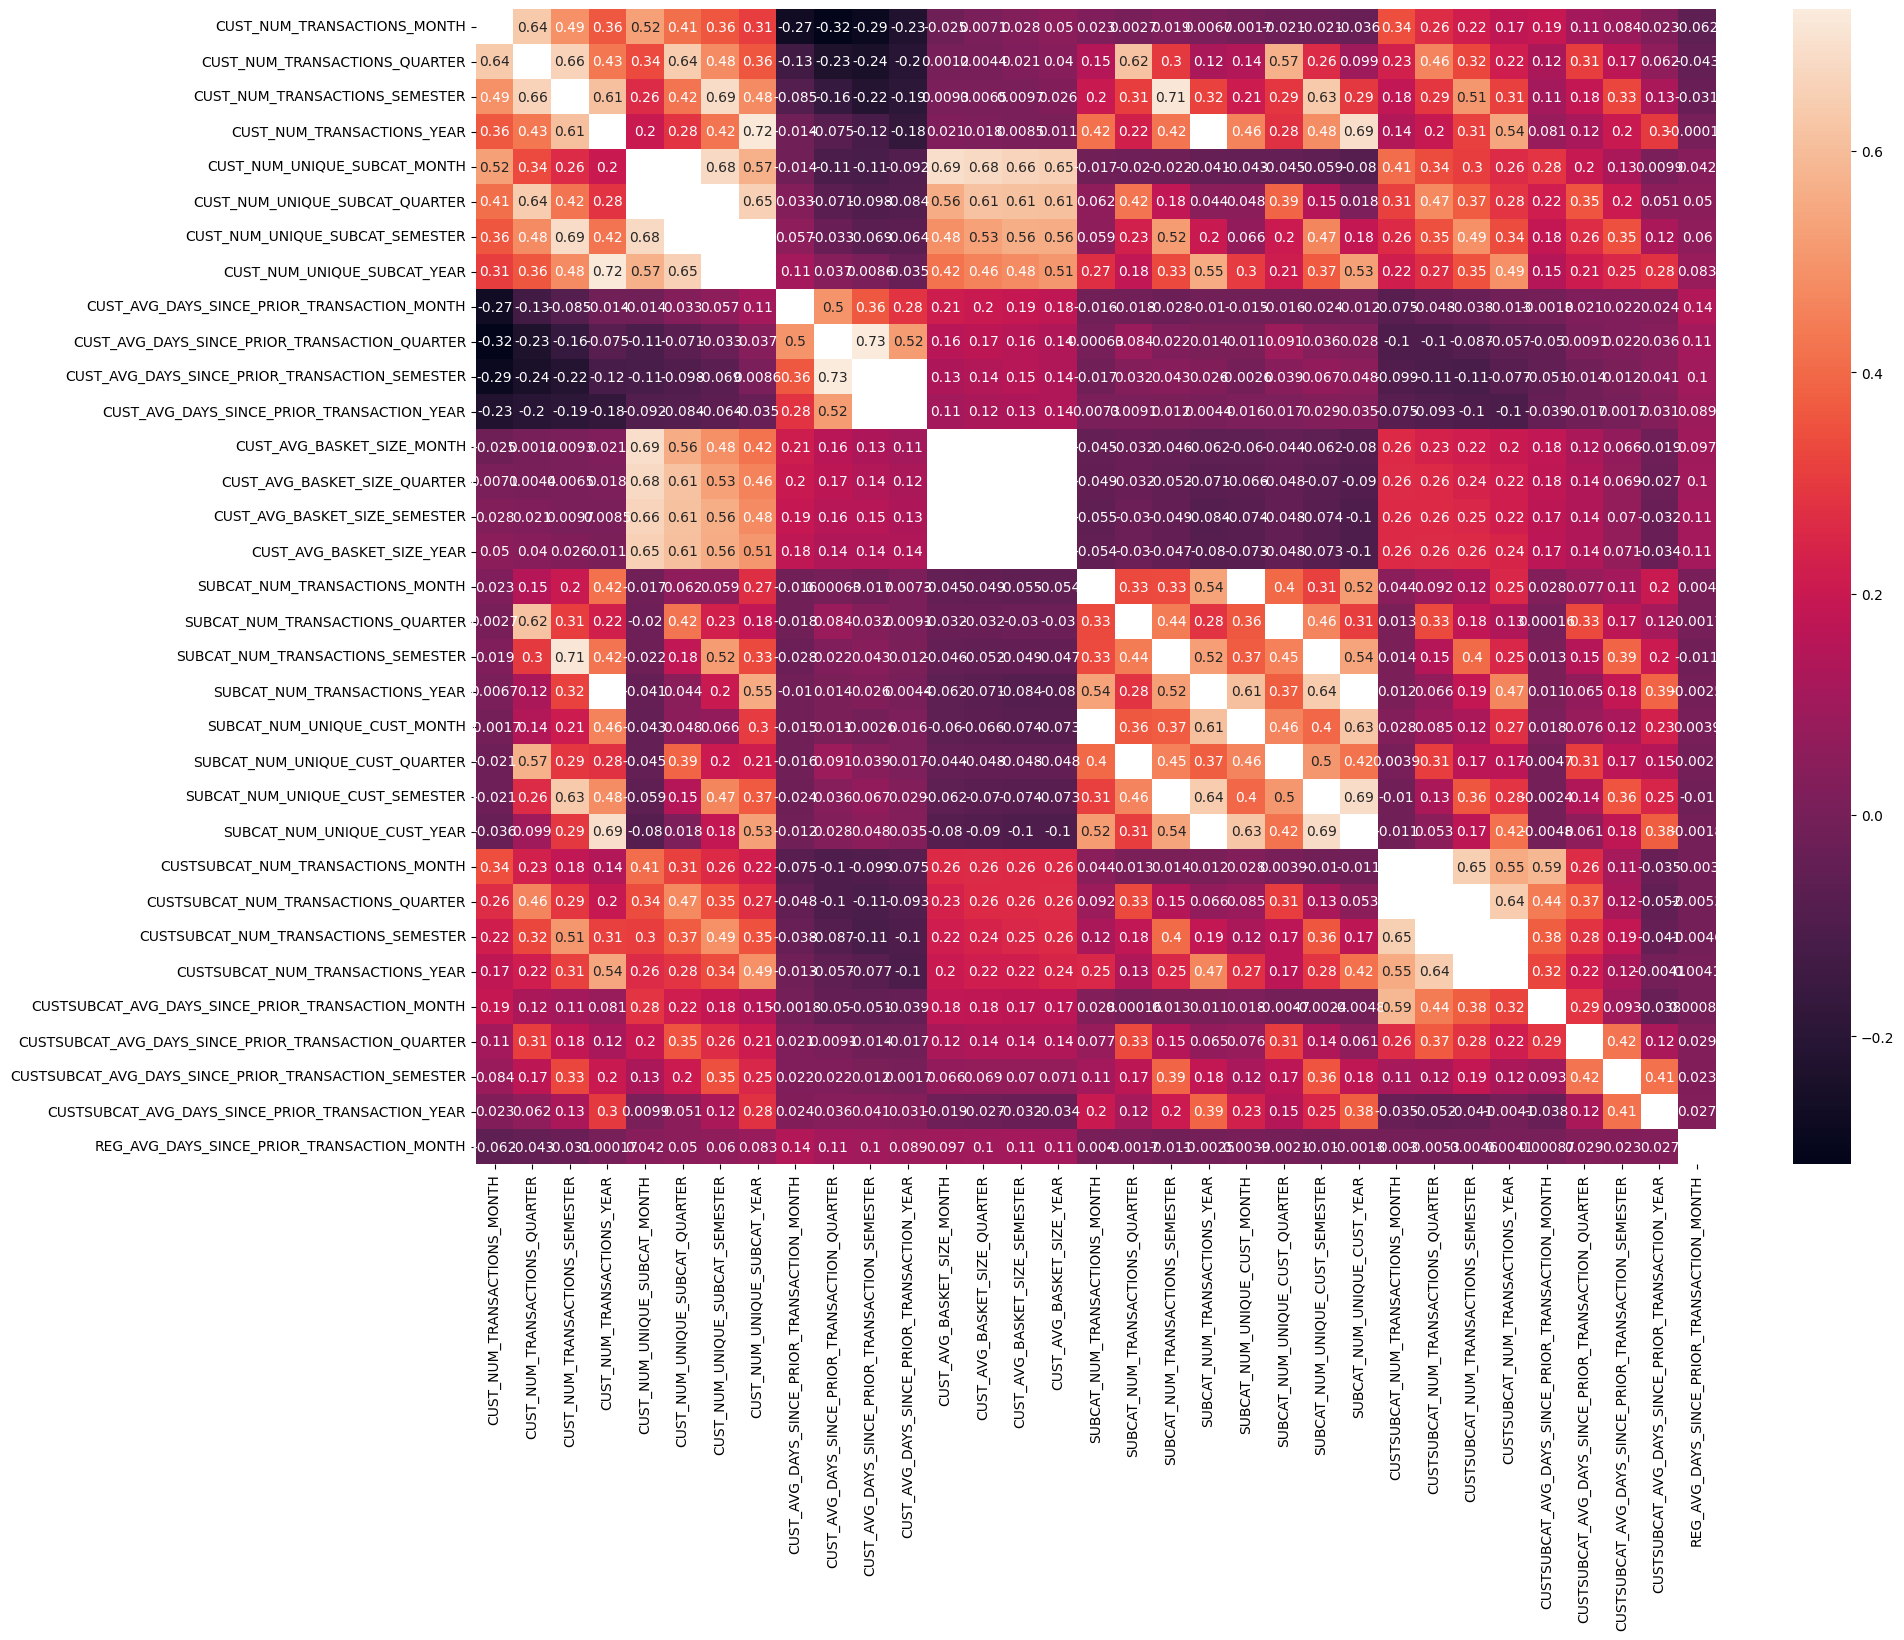

In [57]:
# set the threshold
threshold = 0.75

# keep only the correlations above the threshold
corr = corr[corr < threshold]

# Create the figure and the axes objectsa
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr,annot = True)

In [13]:
# Calculate the correlation matrix
corr = df_200k[numerical_columns].corr()

# Set the threshold
threshold = 0.75

# Filter correlations below the threshold
corr_filtered = corr[corr < threshold]

# Get the list of columns below the threshold
columns_below_threshold = corr_filtered.columns.tolist()

print("Columns below the threshold:")
print(columns_below_threshold)

Columns below the threshold:
['CUST_NUM_TRANSACTIONS_MONTH', 'CUST_NUM_TRANSACTIONS_QUARTER', 'CUST_NUM_TRANSACTIONS_SEMESTER', 'CUST_NUM_TRANSACTIONS_YEAR', 'CUST_NUM_UNIQUE_SUBCAT_MONTH', 'CUST_NUM_UNIQUE_SUBCAT_QUARTER', 'CUST_NUM_UNIQUE_SUBCAT_SEMESTER', 'CUST_NUM_UNIQUE_SUBCAT_YEAR', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR', 'CUST_AVG_BASKET_SIZE_MONTH', 'CUST_AVG_BASKET_SIZE_QUARTER', 'CUST_AVG_BASKET_SIZE_SEMESTER', 'CUST_AVG_BASKET_SIZE_YEAR', 'SUBCAT_NUM_TRANSACTIONS_MONTH', 'SUBCAT_NUM_TRANSACTIONS_QUARTER', 'SUBCAT_NUM_TRANSACTIONS_SEMESTER', 'SUBCAT_NUM_TRANSACTIONS_YEAR', 'SUBCAT_NUM_UNIQUE_CUST_MONTH', 'SUBCAT_NUM_UNIQUE_CUST_QUARTER', 'SUBCAT_NUM_UNIQUE_CUST_SEMESTER', 'SUBCAT_NUM_UNIQUE_CUST_YEAR', 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH', 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER', 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER', 'CUSTSUBCA

## Variance Inflation Index

In [47]:
df_200k = df_200k.drop(columns=['QUARTER','SEMESTER','CAT_CD_EXT', 'YEAR', 'MONTH', 'SUBCAT_CD_EXT'], axis=1)

In [48]:
# One-hot encoding categorical variables
df_200k = pd.get_dummies(df_200k, columns=['GENDER','SEG_LIFESTAGE_CD', 'FAMILY_MEMBERS'])
#df_200k

,CUST_NUM_TRANSACTIONS_MONTH,CUST_NUM_TRANSACTIONS_QUARTER,CUST_NUM_TRANSACTIONS_SEMESTER,CUST_NUM_TRANSACTIONS_YEAR,CUST_TOTAL_QTY_BOUGHT_MONTH,CUST_TOTAL_QTY_BOUGHT_QUARTER,CUST_TOTAL_QTY_BOUGHT_SEMESTER,CUST_TOTAL_QTY_BOUGHT_YEAR,CUST_NUM_UNIQUE_SUBCAT_MONTH,CUST_NUM_UNIQUE_SUBCAT_QUARTER,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,CUST_NUM_UNIQUE_SUBCAT_YEAR,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_BASKET_SIZE_MONTH,CUST_AVG_BASKET_SIZE_QUARTER,CUST_AVG_BASKET_SIZE_SEMESTER,CUST_AVG_BASKET_SIZE_YEAR,SUBCAT_NUM_TRANSACTIONS_MONTH,SUBCAT_NUM_TRANSACTIONS_QUARTER,SUBCAT_NUM_TRANSACTIONS_SEMESTER,SUBCAT_NUM_TRANSACTIONS_YEAR,SUBCAT_TOTAL_QTY_BOUGHT_MONTH,SUBCAT_TOTAL_QTY_BOUGHT_QUARTER,SUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,SUBCAT_TOTAL_QTY_BOUGHT_YEAR,SUBCAT_NUM_UNIQUE_CUST_MONTH,SUBCAT_NUM_UNIQUE_CUST_QUARTER,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,SUBCAT_NUM_UNIQUE_CUST_YEAR,CUSTSUBCAT_NUM_TRANSACTIONS_MONTH,CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER,CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER,CUSTSUBCAT_NUM_TRANSACTIONS_YEAR,CUSTSUBCAT_TOTAL_QTY_BOUGHT_MONTH,CUSTSUBCAT_TOTAL_QTY_BOUGHT_QUARTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_YEAR,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,SEG_LIFESTYLE_CD,TARGET,REG_CUST_NUM_TRANSACTIONS_MONTH,fulldate,GENDER_F,GENDER_M,SEG_LIFESTAGE_CD_1,SEG_LIFESTAGE_CD_2,SEG_LIFESTAGE_CD_3,SEG_LIFESTAGE_CD_4,SEG_LIFESTAGE_CD_5,SEG_LIFESTAGE_CD_6,"FAMILY_MEMBERS_(0, 0)","FAMILY_MEMBERS_(1, 2)","FAMILY_MEMBERS_(3, 8)"
403798,-0.18,-0.83,-1.07,-1.25,17,17,17,17,-1.23,-1.49,-1.72,-1.99,-0.04,-0.18,-0.23,-0.24,6.33,-1.03,-1.13,-1.19,-1.26,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,0.88,0.09,-0.30,-0.57,2,2,2,2,1.60,0.30,-0.15,-0.43,3,0,6,2021-01,1,0,0,1,0,0,0,0,0,0,1
579013,-0.18,-0.83,-1.07,-1.25,25,25,25,25,-0.22,-0.74,-1.09,-1.44,0.34,0.16,0.11,0.13,8.50,-0.67,-0.73,-0.77,-0.82,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,-0.76,-0.80,-0.84,-0.87,0,0,0,0,-0.45,-0.59,-0.70,-0.79,1,0,3,2021-01,1,0,0,0,0,0,1,0,0,1,0
374318,1.78,0.02,-0.60,-1.00,45,45,45,45,0.03,-0.55,-0.93,-1.30,-0.75,-0.81,-0.87,-0.93,3.12,-0.67,-0.73,-0.77,-0.82,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,-0.76,-0.80,-0.84,-0.87,0,0,0,0,-0.45,-0.59,-0.70,-0.79,3,0,11,2021-01,0,1,0,0,0,0,0,1,0,0,1
548490,-0.51,-0.97,-1.15,-1.30,90,90,90,90,1.45,0.51,-0.03,-0.52,0.94,0.70,0.66,0.72,3.33,2.55,2.80,2.93,3.08,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,-0.76,-0.80,-0.84,-0.87,0,0,0,0,-0.45,-0.59,-0.70,-0.79,2,0,4,2021-01,1,0,0,0,0,1,0,0,0,0,1
613234,-0.18,-0.83,-1.07,-1.25,44,44,44,44,-0.05,-0.62,-0.98,-1.35,0.11,-0.04,-0.09,-0.09,10.00,0.02,0.02,0.02,0.01,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,0.88,0.09,-0.30,-0.57,7,7,7,7,0.98,0.03,-0.31,-0.54,3,1,5,2021-01,1,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220603,-0.51,-0.54,-0.05,0.43,44,104,320,747,-0.98,-0.37,0.97,1.17,0.74,1.10,0.85,0.58,0.00,-0.53,0.35,0.80,0.94,-0.12,0.10,1.19,1.55,4822,9860,26423,56430,0.05,0.35,1.41,1.47,-0.76,-0.80,-0.84,0.19,0,0,0,9,-0.45,-0.59,-0.70,-0.06,3,0,4,2022-11,1,0,0,0,0,1,0,0,0,0,1
953621,0.14,-0.26,0.43,0.08,17,48,105,166,-1.06,-0.74,-0.35,-0.52,-0.27,0.46,0.21,1.02,3.33,-0.97,-0.84,-0.99,-1.04,-0.12,0.10,1.19,1.55,4822,9860,26423,56430,0.05,0.35,1.41,1.47,-0.76,-0.80,-0.57,-0.57,0,0,1,2,-0.45,-0.59,-0.70,1.91,2,0,8,2022-11,1,0,0,0,0,0,1,0,1,0,0
690586,-0.84,-0.54,-0.44,0.17,41,104,

In [34]:
# compute the vif for all given features
def compute_vif(considered_features):
    X = df_200k[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    to_keep = vif[vif['VIF'] < 10]
    cols = to_keep['Variable'].tolist()
    
    
    return vif, cols

In [49]:
vif, cols = compute_vif(numerical_columns)

In [50]:
vif.sort_values('VIF', ascending=False)

,Variable,VIF
20,SUBCAT_NUM_UNIQUE_CUST_MONTH,118.03
16,SUBCAT_NUM_TRANSACTIONS_MONTH,100.55
21,SUBCAT_NUM_UNIQUE_CUST_QUARTER,83.83
17,SUBCAT_NUM_TRANSACTIONS_QUARTER,73.65
22,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,43.76
18,SUBCAT_NUM_TRANSACTIONS_SEMESTER,34.82
6,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,26.74
23,SUBCAT_NUM_UNIQUE_CUST_YEAR,23.63
14,CUST_AVG_BASKET_SIZE_SEMESTER,22.90
5,CUST_NUM_UNIQUE_SUBCAT_QUARTER,21.66


In [51]:
num = ['SEG_LIFESTYLE_CD', 'GENDER_F', 'GENDER_M', 'SEG_LIFESTAGE_CD_1',
       'SEG_LIFESTAGE_CD_2', 'SEG_LIFESTAGE_CD_3', 'SEG_LIFESTAGE_CD_4',
       'SEG_LIFESTAGE_CD_5', 'SEG_LIFESTAGE_CD_6', 'FAMILY_MEMBERS_(0, 0)',
       'FAMILY_MEMBERS_(1, 2)', 'FAMILY_MEMBERS_(3, 8)', 'fulldate', 'REG_CUST_NUM_TRANSACTIONS_MONTH']

df_200k = df_200k[cols + num]

# Machine Learning

In [52]:
results_df = pd.DataFrame()

In [92]:
def plot_regression_results(y_true, y_pred):
    plt.scatter(y_true, y_pred, color='red', alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='#970707', linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True Values vs Predicted Values')
    plt.show()

In [86]:
def reg_metrics(pred_model, x_train, x_test, y_train, y_test):
    """ Function takes in training and testing sets, prediction model, 
    and ouputs the below metrics:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    """
    global r2
    global adj_r2
    global mse
    global rmse
    global mae
    global mape

    

    # Get predicted values on x_test
    y_pred = pred_model.predict(x_test)

    #1 & 2 Coefficient of Determination (R² & Adjusted R²)
    print("\n\t--- Coefficient of Determination (R² & Adjusted R²) ---")
    r2 = metrics.r2_score(y_pred=y_pred, y_true=y_test)
    adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

    print(f"R²\t\t: {r2:.2f}")
    print(f"Adjusted R²\t: {adj_r2:.2f}")

    #3 & 4. MSE and RMSE
    print("\n\t--- Mean Squared Error (MSE & RMSE) ---")
   
    mse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
    rmse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
    
    print(f"MSE\t: {mse:.2f}")
    print(f"RMSE\t: {rmse:.2f}")

    #5. MAE
    print("\n\t--- Mean Absolute Error (MAE) ---")
    mae = metrics.mean_absolute_error(y_pred=y_pred, y_true=y_test)
    print(f"RMSE\t: {mae:.2f}")

    print("\n\t--- Mean Absolute Percentage Error (MAPE) ---")
    mape = metrics.mean_absolute_percentage_error(y_pred=y_pred, y_true=y_test)
    print(f"MAPE\t: {mape:.2f}")
    

    plot_regression_results(y_true=y_test, y_pred=y_pred)
    # # Return Accuracy
    # #train_acc = "{:.2f}".format(pred_model.score(x_train, y_train)*100)
    # #test_acc = "{:.2f}".format(pred_model.score(x_test, y_test)*100)
    
    # #Convert variables to a rounded format 
    # r2_formatted = "{:.2f}%".format(r2 * 100)
    # adj_r2_formatted = "{:.2f}%".format(adj_r2 * 100)
    # mse_formatted = "{:.2f}".format(mse)
    # rmse_formatted = "{:.2f}".format(rmse)
    # mae_formatted = "{:.2f}".format(mae)
    
    # # Return metrics as a dictionary
    # metrics_dict = {
    #     'R²': r2_formatted,
    #     'Adjusted R²': adj_r2_formatted,
    #     'MSE': mse_formatted,
    #     'RMSE': rmse_formatted,
    #     'MAE': mae_formatted
    # }
    
    #return metrics_dict

In [73]:
def cross_val_reg(df_ML, model, model_name):
    global results_df
    print(f'\t------- {model_name} -------\n')

    timestamps = df_ML['fulldate'].sort_values().unique()

    # store each of the metrics in an array for each one
    rsquared_array = np.array([])
    adjrsquared_array = np.array([])
    mse_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])
    mape_array = np.array([])

    i = 0
    ii = 1
    max_timestamp = timestamps.max() - 2
    while timestamps[i] < max_timestamp:
            print('\n')
            print('-' * 50)
            print(f'\n\n\t---- Start Iteration {ii} ----\n')
            print("\n\t----- Iteration Info -----")
            print(f'\nTreino feito com os meses: {timestamps[i]} até {timestamps[i]+2}') # 11   
            train = df_ML[df_ML['fulldate'].isin([timestamps[i], timestamps[i]+1, timestamps[i]+2])]
            print(f'Teste feito com o mês: {timestamps[i]+3}\n')

            # test and train split
            train_tune = train.groupby('fulldate').sample(frac=0.3, random_state=101)
            train_tune.value_counts('fulldate').sort_index()
            X_train_cv = train.drop(['REG_CUST_NUM_TRANSACTIONS_MONTH','fulldate'], axis=1)
            y_train_cv = train['REG_CUST_NUM_TRANSACTIONS_MONTH'].astype(int)
            y_train_cv.value_counts('fulldate').sort_index()
            X_train_tune = train_tune.drop(['REG_CUST_NUM_TRANSACTIONS_MONTH','fulldate'], axis=1)
            y_train_tune = train_tune['REG_CUST_NUM_TRANSACTIONS_MONTH'].astype(int)
            y_train_tune.value_counts('fulldate').sort_index() 
                           
            # resampling technique
            #X_train_cv, y_train_cv = resampling_tecnique(X_train_cv, y_train_cv)
            #X_train_tune, y_train_tune = random_undersampling(X_train_tune, y_train_tune)

            print('X_train_cv shape: ', X_train_cv.shape)
            print('X_train_tune shape: ', X_train_tune.shape)
            
            test = df_ML[df_ML['fulldate'] == timestamps[i]+3] # 12
            
            X_test = test.drop(['REG_CUST_NUM_TRANSACTIONS_MONTH', 'fulldate'], axis=1)
            #X_test.value_counts('fulldate').sort_index() 
            y_test = test['REG_CUST_NUM_TRANSACTIONS_MONTH'].astype(int)
            y_test.value_counts('fulldate').sort_index() 
            print('X_test shape: ', X_test.shape)
            print('\n\t--------------------------')
            # predictions for metrics
            y_pred = model(X_train_cv, y_train_cv, X_train_tune, y_train_tune, X_test, y_test)
            
            #append rsquared to rsquared_array
            rsquared_array = np.append(rsquared_array, r2)
            #append adjrsquared to ajdrsquared_array
            adjrsquared_array = np.append(adjrsquared_array, adj_r2)
            #append mse to mse_array
            mse_array = np.append(mse_array, mse)
            #append rmse to rmse_array
            rmse_array = np.append(rmse_array, rmse)
            #append mae to mae_array
            mae_array = np.append(mae_array, mae)
            #append mape to mape_array
            mape_array = np.append(mape_array, mape)
            
            i += 1
            ii += 1
    else:
        print('\n----------------------------\n\n')
        print(f'R² Mean of all iterations : {np.mean(rsquared_array)}')
        print(f'Adjusted R² Mean of all iterations : {np.mean(adjrsquared_array)}')
        print(f'MSE Mean of all iterations: {np.mean(mse_array)}')
        print(f'RMSE mean of all iterations: {np.mean(rmse_array)}')
        print(f'MAE mean of all iterations: {np.mean(mae_array)}')
        print(f'MAPE mean of all iterations: {np.mean(mape_array)}')

        # Append the results to the dataframe
        results_df = results_df.append({
        'Model': model_name,  # Replace 'Model Name' with the actual model name
        'R² Mean': np.mean(rsquared_array),
        'Adjusted R² Mean': np.mean(adjrsquared_array),
        'MSE Mean': np.mean(mse_array),
        'RMSE Mean': np.mean(rmse_array),
        'MAE Mean': np.mean(mae_array)}, ignore_index=True)
        
    return X_train_cv, y_train_cv,X_test, y_test, y_pred, results_df 



In [71]:
df_200k = df_200k[df_200k['REG_CUST_NUM_TRANSACTIONS_MONTH'] != 0]

In [76]:
feature_df = pd.DataFrame()

In [88]:
def LR(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    global feature_df
    start_time = time.time()
    clf = Pipeline([
        # ('pca', PCA()),
        ('clf', LinearRegression())
    ])
    param_grid = {}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf, n_features_to_select='auto', direction='forward',
                                             scoring='neg_mean_squared_error', cv=None, n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)
    print(f'X_train Shape: {X_train.shape}')

    print('\n\nNumber of selected features: {}'.format(sfs_backward.n_features_to_select_))
    print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    LR = Pipeline([('gs', gs)])

    LR.fit(X_train, y_train)
    feature_importance = LR.named_steps['gs'].best_estimator_.named_steps['clf'].coef_
    feature_names = sfs_backward.feature_names_in_[sfs_backward.support_]
    
    # Create a dictionary with feature names and their corresponding importances
    feature_importance_dict = dict(zip(feature_names, feature_importance))

    # Sort the dictionary by importance (optional)
    feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: abs(item[1]), reverse=True))

    # Create a dataframe from the dictionary
    #df_feature_importance = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['Importance'])
    for feature, importance in feature_importance_dict.items():
        feature_df = feature_df.append({'Feature': feature, 'Importance': importance}, ignore_index=True)


    end_time = time.time()
    diff = end_time - start_time
    print(f'Time: {diff}')
    reg_metrics(LR, X_train, X_test, y_train, y_test)
    return feature_df


In [95]:
def ridge(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    start_time = time.time()
    clf = Pipeline([
                # ('pca', PCA()),
                ('clf', Ridge(max_iter=1000, tol=11.830e-06))])  

    param_grid = {
    'clf__alpha': (np.arange(0.001,1.0,0.005))}
    #'clf__alpha': [0.01]}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf['clf'], n_features_to_select=0.5, direction='forward', scoring='r2', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))
        
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    RG = Pipeline([('gs', gs)]) 
        
    RG.fit(X_train,y_train)
    
    # get best parameters
    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')

    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = RG.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')
    end_time = time.time()
    diff = end_time - start_time
    print(f'Time: {diff}')
    reg_metrics(RG, X_train, X_test, y_train, y_test)

In [77]:
def lasso(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
                # ('pca', PCA()),
                ('clf', Lasso(max_iter=1000, tol=11.830e-06))])  

    param_grid = {
    'clf__alpha': (np.arange(0.001,1.0,0.001))}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf, n_features_to_select=0.5, direction='forward', scoring='r2', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)


    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_])
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    LS = Pipeline([('gs', gs)]) 
        
    LS.fit(X_train,y_train)

    # get best parameters
    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')

    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = LS.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(LS, X_train, X_test, y_train, y_test)


In [78]:
def ElasticNetRegression(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
        # ('pca', PCA()),
        ('clf', ElasticNet(max_iter=10000,tol=11.830e-06))])

    param_grid = {
        'clf__alpha': (np.arange(0.001,1.0,0.001))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select=0.5, direction='forward', scoring='neg_mean_squared_error', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2, verbose=1,
                      n_jobs=-1)
    EN = Pipeline([('gs', gs)])

    EN.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = EN.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(EN, X_train, X_test, y_train, y_test)

In [214]:
def gradientboostingreg(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    start_time = time.time()
    clf = Pipeline([
    # ('pca', PCA()),
    ('clf', GradientBoostingRegressor())])

    param_grid = {
        'clf__alpha': (np.arange(0.001,1.0,0.005))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select='auto', direction='forward', scoring='r2', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1,
                      n_jobs=-1)
    GB = Pipeline([('gs', gs)])

    GB.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = GB.named_steps['gs'].best_estimator_['clf']

    # Get feature importances
    feature_importances = final_estimator.feature_importances_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')
    end_time = time.time()
    diff = end_time - start_time
    print(diff)

    reg_metrics(GB, X_train, X_test, y_train, y_test)

In [80]:
def randomforestreg(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
    # ('pca', PCA()),
    ('clf', RandomForestRegressor())])

    param_grid = {
        'clf__min_samples_split': (range(1,30,1)),
        'clf__min_samples_leaf': (range(1,30,1))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select='auto', direction='forward', scoring='r2', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1,
                      n_jobs=-1)
    RF = Pipeline([('gs', gs)])

    RF.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = RF.named_steps['gs'].best_estimator_['clf']

    # Get feature importances
    feature_importances = final_estimator.feature_importances_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(RF, X_train, X_test, y_train, y_test)

In [217]:
def xgboost_regressor(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    start_time = time.time()
    clf = Pipeline([
        ('xgb', xgb.XGBRegressor())])

    param_grid = {
        'xgb__learning_rate': [0.001, 0.01, 0.1],
        'xgb__n_estimators': [100, 500, 1000],
        'xgb__max_depth': [3, 5, 7]
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf['xgb'], n_features_to_select=0.5, direction='forward', scoring='r2', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    XGBoost_reg = Pipeline([('gs', gs)]) 

    XGBoost_reg.fit(X_train, y_train)

    # Get best parameters
    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')

    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = XGBoost_reg.named_steps['gs'].best_estimator_['xgb']

    # Get feature importances
    feature_importances = final_estimator.feature_importances_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')
    end_time = time.time()
    diff = end_time - start_time
    print(diff)
    reg_metrics(XGBoost_reg, X_train, X_test, y_train, y_test)

	------- Linear Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2809, 26)
X_train_tune shape:  (842, 26)
X_test shape:  (953, 26)

	--------------------------
X_train Shape: (2809, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH' 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTYLE_CD'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_2' 'SEG_LIFESTAGE_CD_5'
 'SEG_LIFESTAGE_CD_6' 'FAMILY_MEMBERS_(1, 2)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 5.086161851882935

	--- Coefficient of Determination (R² & Adjusted R²) 

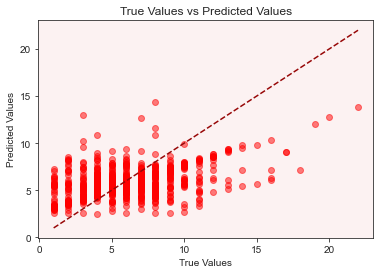



--------------------------------------------------


	---- Start Iteration 2 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-02 até 2021-04
Teste feito com o mês: 2021-05

X_train_cv shape:  (2844, 26)
X_train_tune shape:  (853, 26)
X_test shape:  (974, 26)

	--------------------------
X_train Shape: (2844, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'
 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER' 'CUSTSUBCAT_NUM_TRANSACTIONS_YEAR'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'GENDER_F' 'GENDER_M'
 'SEG_LIFESTAGE_CD_5' 'SEG_LIFESTAGE_CD_6' 'FAMILY_MEMBERS_(0, 0)'
 'FAMILY_MEMBERS_(1, 2)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 5.279289245605469

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.25
Adjusted R²	: 0.25

	--- Mean Squared Erro

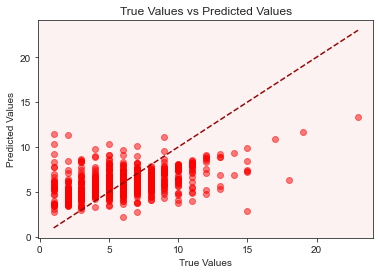



--------------------------------------------------


	---- Start Iteration 3 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-03 até 2021-05
Teste feito com o mês: 2021-06

X_train_cv shape:  (2881, 26)
X_train_tune shape:  (864, 26)
X_test shape:  (971, 26)

	--------------------------
X_train Shape: (2881, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'
 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_2' 'SEG_LIFESTAGE_CD_3'
 'SEG_LIFESTAGE_CD_6' 'FAMILY_MEMBERS_(0, 0)' 'FAMILY_MEMBERS_(1, 2)'
 'FAMILY_MEMBERS_(3, 8)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 5.387738227844238

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.26
Adjusted R²	: 0.26

	--- Mean Squa

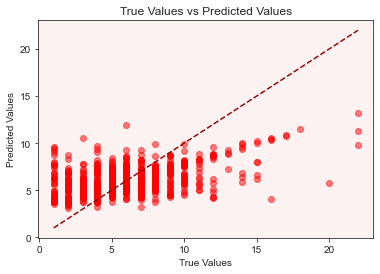



--------------------------------------------------


	---- Start Iteration 4 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-04 até 2021-06
Teste feito com o mês: 2021-07

X_train_cv shape:  (2898, 26)
X_train_tune shape:  (869, 26)
X_test shape:  (957, 26)

	--------------------------
X_train Shape: (2898, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'
 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER' 'CUSTSUBCAT_NUM_TRANSACTIONS_YEAR'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTYLE_CD'
 'GENDER_F' 'GENDER_M' 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_6'
 'FAMILY_MEMBERS_(0, 0)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 7.929120063781738

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.23
Adjusted R²	: 0.23

	--- Mean Squared

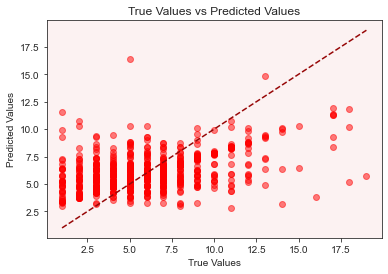



--------------------------------------------------


	---- Start Iteration 5 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-05 até 2021-07
Teste feito com o mês: 2021-08

X_train_cv shape:  (2902, 26)
X_train_tune shape:  (870, 26)
X_test shape:  (954, 26)

	--------------------------
X_train Shape: (2902, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'
 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER' 'SEG_LIFESTYLE_CD'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_2' 'SEG_LIFESTAGE_CD_4'
 'SEG_LIFESTAGE_CD_6' 'FAMILY_MEMBERS_(0, 0)' 'FAMILY_MEMBERS_(1, 2)'
 'FAMILY_MEMBERS_(3, 8)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 7.488868236541748

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.39
Adjusted R²	: 0.39

	--- Mean Squared Error (MSE & RMSE) --

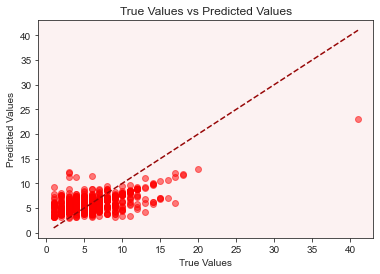



--------------------------------------------------


	---- Start Iteration 6 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-06 até 2021-08
Teste feito com o mês: 2021-09

X_train_cv shape:  (2882, 26)
X_train_tune shape:  (864, 26)
X_test shape:  (976, 26)

	--------------------------
X_train Shape: (2882, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'
 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER' 'SEG_LIFESTYLE_CD'
 'GENDER_F' 'GENDER_M' 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_6'
 'FAMILY_MEMBERS_(0, 0)' 'FAMILY_MEMBERS_(1, 2)' 'FAMILY_MEMBERS_(3, 8)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 5.198598146438599

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.45
Adjusted R²	: 0.44

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 5.01
RMSE	

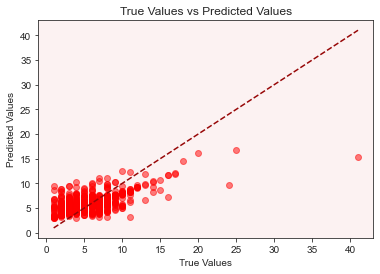



--------------------------------------------------


	---- Start Iteration 7 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-07 até 2021-09
Teste feito com o mês: 2021-10

X_train_cv shape:  (2887, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (979, 26)

	--------------------------
X_train Shape: (2887, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'
 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTYLE_CD'
 'GENDER_F' 'GENDER_M' 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_2'
 'SEG_LIFESTAGE_CD_3' 'SEG_LIFESTAGE_CD_6' 'FAMILY_MEMBERS_(0, 0)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 5.421782970428467

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.39
Adjusted R²	: 0.39

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 5.27
RMSE	: 2.30

	---

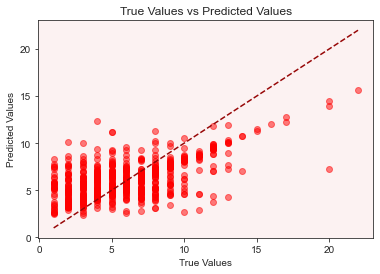



--------------------------------------------------


	---- Start Iteration 8 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-08 até 2021-10
Teste feito com o mês: 2021-11

X_train_cv shape:  (2909, 26)
X_train_tune shape:  (873, 26)
X_test shape:  (972, 26)

	--------------------------
X_train Shape: (2909, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER' 'GENDER_M'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_3' 'SEG_LIFESTAGE_CD_6'
 'FAMILY_MEMBERS_(0, 0)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 11.338497877120972

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²

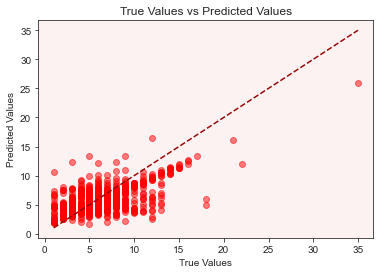



--------------------------------------------------


	---- Start Iteration 9 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-09 até 2021-11
Teste feito com o mês: 2021-12

X_train_cv shape:  (2927, 26)
X_train_tune shape:  (879, 26)
X_test shape:  (969, 26)

	--------------------------
X_train Shape: (2927, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTYLE_CD'
 'GENDER_F' 'GENDER_M' 'SEG_LIFESTAGE_CD_3' 'SEG_LIFESTAGE_CD_5'
 'SEG_LIFESTAGE_CD_6']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 8.274332046508789

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.27
Adjusted R²	: 0.27

	--- Mean Squared Error (MSE & 

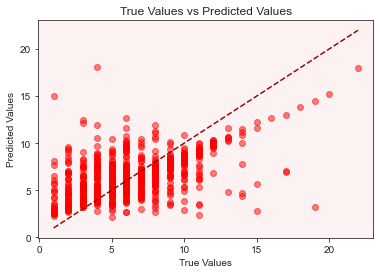



--------------------------------------------------


	---- Start Iteration 10 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-10 até 2021-12
Teste feito com o mês: 2022-01

X_train_cv shape:  (2920, 26)
X_train_tune shape:  (877, 26)
X_test shape:  (979, 26)

	--------------------------
X_train Shape: (2920, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'
 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER' 'CUSTSUBCAT_NUM_TRANSACTIONS_YEAR'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTYLE_CD'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_3' 'SEG_LIFESTAGE_CD_6'
 'FAMILY_MEMBERS_(1, 2)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 6.544041872024536

	--- Coefficient of Determination (R² & Adjusted R²) -

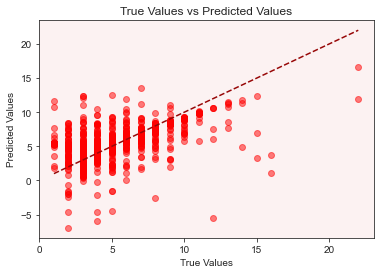



--------------------------------------------------


	---- Start Iteration 11 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-11 até 2022-01
Teste feito com o mês: 2022-02

X_train_cv shape:  (2920, 26)
X_train_tune shape:  (877, 26)
X_test shape:  (957, 26)

	--------------------------
X_train Shape: (2920, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER' 'CUSTSUBCAT_NUM_TRANSACTIONS_YEAR'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER' 'SEG_LIFESTYLE_CD'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_2' 'SEG_LIFESTAGE_CD_3'
 'SEG_LIFESTAGE_CD_6' 'FAMILY_MEMBERS_(3, 8)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 7.315664768218994

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.29
Adjusted R²	: 0.29

	--- Mean Sq

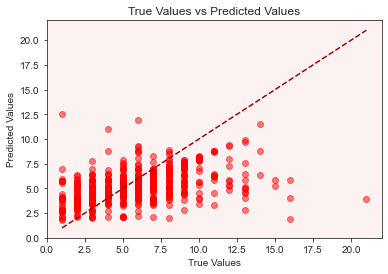



--------------------------------------------------


	---- Start Iteration 12 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-12 até 2022-02
Teste feito com o mês: 2022-03

X_train_cv shape:  (2905, 26)
X_train_tune shape:  (872, 26)
X_test shape:  (951, 26)

	--------------------------
X_train Shape: (2905, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'GENDER_F' 'GENDER_M'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_2' 'SEG_LIFESTAGE_CD_3'
 'SEG_LIFESTAGE_CD_6']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 7.242609739303589

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.29
Adjusted R²	: 0.29

	--- Mean Squar

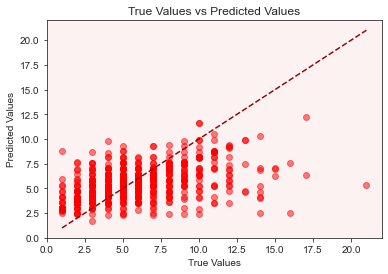



--------------------------------------------------


	---- Start Iteration 13 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-01 até 2022-03
Teste feito com o mês: 2022-04

X_train_cv shape:  (2887, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (955, 26)

	--------------------------
X_train Shape: (2887, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'GENDER_F'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_6' 'FAMILY_MEMBERS_(0, 0)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 7.882800102233887

	--- Coefficient of Determination (R² & Adjusted R

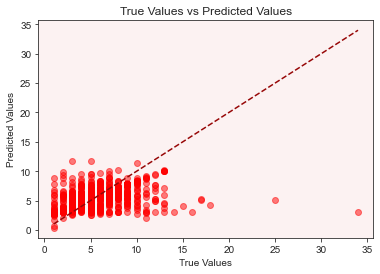



--------------------------------------------------


	---- Start Iteration 14 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-02 até 2022-04
Teste feito com o mês: 2022-05

X_train_cv shape:  (2863, 26)
X_train_tune shape:  (858, 26)
X_test shape:  (953, 26)

	--------------------------
X_train Shape: (2863, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'GENDER_F'
 'SEG_LIFESTAGE_CD_2' 'SEG_LIFESTAGE_CD_5' 'FAMILY_MEMBERS_(0, 0)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 8.79200291633606

	--- Coefficient of Determination (R² & Adju

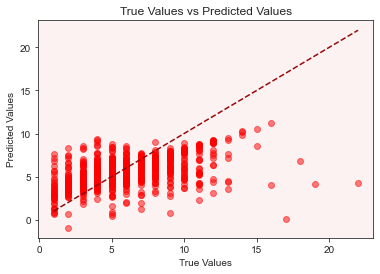



--------------------------------------------------


	---- Start Iteration 15 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-03 até 2022-05
Teste feito com o mês: 2022-06

X_train_cv shape:  (2859, 26)
X_train_tune shape:  (857, 26)
X_test shape:  (958, 26)

	--------------------------
X_train Shape: (2859, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER' 'SEG_LIFESTYLE_CD'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_2' 'SEG_LIFESTAGE_CD_6'
 'FAMILY_MEMBERS_(1, 2)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 7.246165037155151

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.15
Adjust

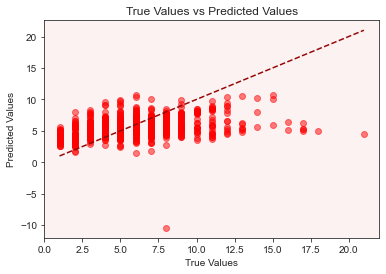



--------------------------------------------------


	---- Start Iteration 16 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-04 até 2022-06
Teste feito com o mês: 2022-07

X_train_cv shape:  (2866, 26)
X_train_tune shape:  (859, 26)
X_test shape:  (949, 26)

	--------------------------
X_train Shape: (2866, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTYLE_CD'
 'GENDER_F' 'GENDER_M' 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_5'
 'SEG_LIFESTAGE_CD_6' 'FAMILY_MEMBERS_(0, 0)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 5.219865083694458

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.22
Adjusted R²	: 0.21

	--- Mean Squared Error (MSE & RMSE

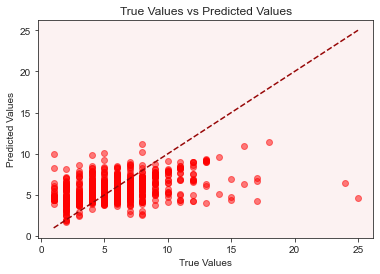



--------------------------------------------------


	---- Start Iteration 17 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-05 até 2022-07
Teste feito com o mês: 2022-08

X_train_cv shape:  (2860, 26)
X_train_tune shape:  (858, 26)
X_test shape:  (951, 26)

	--------------------------
X_train Shape: (2860, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_YEAR'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER' 'SEG_LIFESTYLE_CD'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_5' 'SEG_LIFESTAGE_CD_6'
 'FAMILY_MEMBERS_(1, 2)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 5.522180080413818

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.24
Adjust

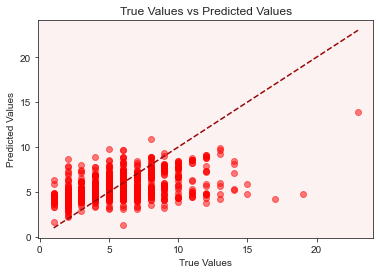



--------------------------------------------------


	---- Start Iteration 18 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-06 até 2022-08
Teste feito com o mês: 2022-09

X_train_cv shape:  (2858, 26)
X_train_tune shape:  (857, 26)
X_test shape:  (939, 26)

	--------------------------
X_train Shape: (2858, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'SEG_LIFESTYLE_CD' 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_2'
 'SEG_LIFESTAGE_CD_3' 'SEG_LIFESTAGE_CD_4' 'SEG_LIFESTAGE_CD_6'
 'FAMILY_MEMBERS_(0, 0)' 'FAMILY_MEMBERS_(1, 2)' 'FAMILY_MEMBERS_(3, 8)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 5.149790048599243

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.28
Adjusted R²	: 0.27

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 5.69
RMSE	: 2.39

	--- Mean Absolute

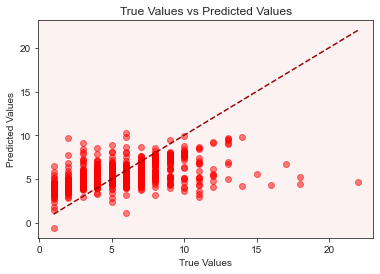



--------------------------------------------------


	---- Start Iteration 19 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-07 até 2022-09
Teste feito com o mês: 2022-10

X_train_cv shape:  (2839, 26)
X_train_tune shape:  (852, 26)
X_test shape:  (939, 26)

	--------------------------
X_train Shape: (2839, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTYLE_CD'
 'GENDER_F' 'GENDER_M' 'SEG_LIFESTAGE_CD_4']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 9.8956618309021

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.28
Adj

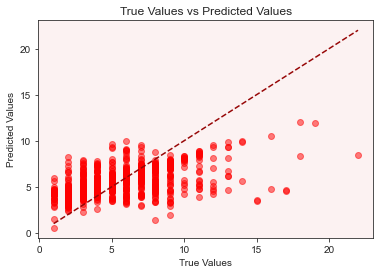



--------------------------------------------------


	---- Start Iteration 20 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-08 até 2022-10
Teste feito com o mês: 2022-11

X_train_cv shape:  (2829, 26)
X_train_tune shape:  (849, 26)
X_test shape:  (949, 26)

	--------------------------
X_train Shape: (2829, 13)


Number of selected features: 13
Features selected: ['CUST_NUM_TRANSACTIONS_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'
 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'CUST_AVG_BASKET_SIZE_MONTH'
 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER'
 'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR' 'SEG_LIFESTYLE_CD'
 'SEG_LIFESTAGE_CD_1' 'SEG_LIFESTAGE_CD_4' 'SEG_LIFESTAGE_CD_5'
 'FAMILY_MEMBERS_(1, 2)']
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Time: 8.63335394859314

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.1

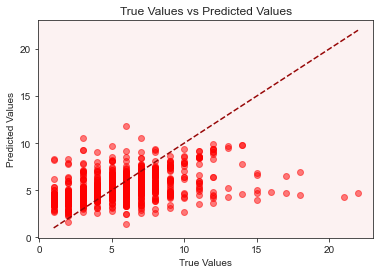


----------------------------


R² Mean of all iterations : 0.26543815236667545
Adjusted R² Mean of all iterations : 0.26210160854135084
MSE Mean of all iterations: 6.198670474996831
RMSE mean of all iterations: 2.486625042640135
MAE mean of all iterations: 1.7341065767658015
MAPE mean of all iterations: 0.4668486638483542


In [93]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, LR, 'Linear Regression')

	------- Ridge Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2809, 26)
X_train_tune shape:  (842, 26)
X_test shape:  (953, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.49934484228634623548
Feature: 1, Score: -0.09901108815636015803
Feature: 2, Score: 0.10364384105898331867
Feature: 3, Score: 0.06288009070386255117
Feature: 4, Score: 0.03560692889841034908
Feature: 5, Score: 0.05247598108671058109
Feature: 6, Score: 0.03263431414707750056
Feature: 7, Score: 0.02173235217354390833
Feature: 8, Score: -0.17277960

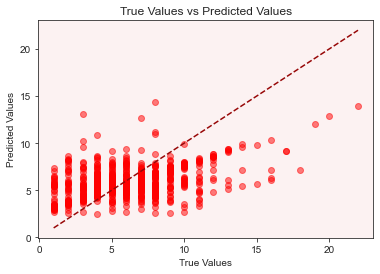



--------------------------------------------------


	---- Start Iteration 2 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-02 até 2021-04
Teste feito com o mês: 2021-05

X_train_cv shape:  (2844, 26)
X_train_tune shape:  (853, 26)
X_test shape:  (974, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.24301357836638048937
Feature: 1, Score: -0.13827012001491001403
Feature: 2, Score: -0.13972342370342247242
Feature: 3, Score: -0.07610946338040856796
Feature: 4, Score: -0.08199367109456771885
Feature: 5, Score: 0.10690090676905411593
Feature: 6, Score: 0.06053447035169330637
Feature: 7, Score: 0.06346930507352363526
Feature: 8, Score: -0.06346930507339952621
Feature: 9, Score: 

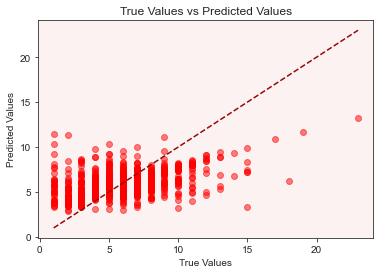



--------------------------------------------------


	---- Start Iteration 3 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-03 até 2021-05
Teste feito com o mês: 2021-06

X_train_cv shape:  (2881, 26)
X_train_tune shape:  (864, 26)
X_test shape:  (971, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.31594183737704195636
Feature: 1, Score: -0.14348090157118603694
Feature: 2, Score: -0.09045609168383260401
Feature: 3, Score: -0.09744947212594719244
Feature: 4, Score: 0.00375171500010332412
Feature: 5, Score: 0.10519236599246656327
Feature: 6, Score: -1.45133989857044642946
Feature: 7, Score: 0.18231171035533519365
Feature: 8, Score: -0.22948461091656735533
Feature: 9, Score: 

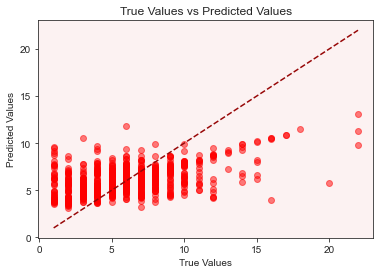



--------------------------------------------------


	---- Start Iteration 4 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-04 até 2021-06
Teste feito com o mês: 2021-07

X_train_cv shape:  (2898, 26)
X_train_tune shape:  (869, 26)
X_test shape:  (957, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.50835015880570466607
Feature: 1, Score: -0.07469384193560221763
Feature: 2, Score: 0.07151288636745017913
Feature: 3, Score: 0.04049539737815148477
Feature: 4, Score: -0.04029373444432259033
Feature: 5, Score: 0.03677699111377985552
Feature: 6, Score: 0.00155018894388244690
Feature: 7, Score: 0.00103232603295159184
Feature: 8, Score: 0.05057247693027806107
Feature: 9, Score: -0.

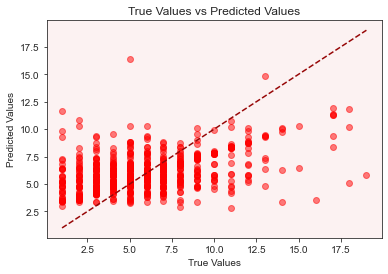



--------------------------------------------------


	---- Start Iteration 5 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-05 até 2021-07
Teste feito com o mês: 2021-08

X_train_cv shape:  (2902, 26)
X_train_tune shape:  (870, 26)
X_test shape:  (954, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.50055610240739101258
Feature: 1, Score: -0.19388232745098343823
Feature: 2, Score: 0.01384940121605251692
Feature: 3, Score: 0.02220653248921598474
Feature: 4, Score: -0.05026453580476615557
Feature: 5, Score: 0.08025105136566132447
Feature: 6, Score: 0.04395098483208310924
Feature: 7, Score: 0.08719007035008621842
Feature: 8, Score: 0.21882777851667184477
Feature: 9, Score: -0.

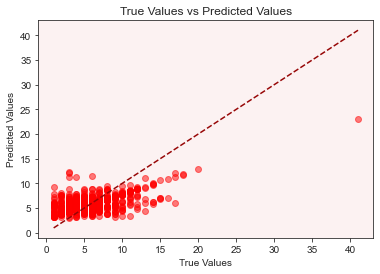



--------------------------------------------------


	---- Start Iteration 6 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-06 até 2021-08
Teste feito com o mês: 2021-09

X_train_cv shape:  (2882, 26)
X_train_tune shape:  (864, 26)
X_test shape:  (976, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.771}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.63162031886329361718
Feature: 1, Score: -0.39929410563767320230
Feature: 2, Score: -0.02754393106507216707
Feature: 3, Score: 0.05531692288563180154
Feature: 4, Score: -0.00971188210236786573
Feature: 5, Score: 0.06672554244964828962
Feature: 6, Score: -0.05000371015851459711
Feature: 7, Score: 0.05000371015851592243
Feature: 8, Score: 0.70366606264568343221
Feature: 9, Score: 2

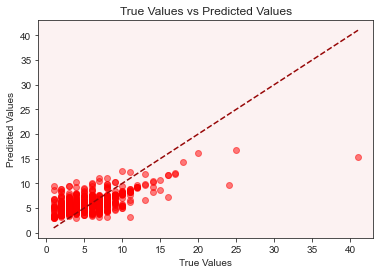



--------------------------------------------------


	---- Start Iteration 7 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-07 até 2021-09
Teste feito com o mês: 2021-10

X_train_cv shape:  (2887, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (979, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.211}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.81102542170053637527
Feature: 1, Score: -0.44840790148456738384
Feature: 2, Score: -0.10739707248943310136
Feature: 3, Score: 0.05797443964732169192
Feature: 4, Score: 0.04308345726708324303
Feature: 5, Score: 0.06068423011510095527
Feature: 6, Score: -0.07046821805117528537
Feature: 7, Score: 0.07046821805056630028
Feature: 8, Score: 2.13174729719108979609
Feature: 9, Score: 0.

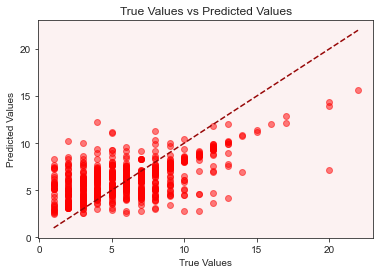



--------------------------------------------------


	---- Start Iteration 8 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-08 até 2021-10
Teste feito com o mês: 2021-11

X_train_cv shape:  (2909, 26)
X_train_tune shape:  (873, 26)
X_test shape:  (972, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.96112687205669056212
Feature: 1, Score: 0.11551219080022775976
Feature: 2, Score: -0.94956544912975493489
Feature: 3, Score: -0.03117929403557486226
Feature: 4, Score: -0.01798189903062336406
Feature: 5, Score: 0.04626243708885335176
Feature: 6, Score: 0.11137940193686607371
Feature: 7, Score: -0.13821060689187614212
Feature: 8, Score: 0.70831331200574054741
Feature: 9, Score: -

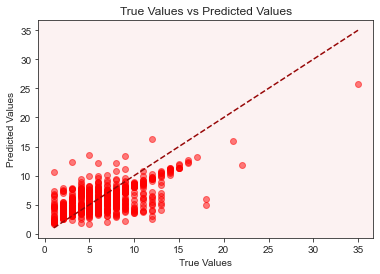



--------------------------------------------------


	---- Start Iteration 9 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-09 até 2021-11
Teste feito com o mês: 2021-12

X_train_cv shape:  (2927, 26)
X_train_tune shape:  (879, 26)
X_test shape:  (969, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.92107422658531690196
Feature: 1, Score: 0.07211002727678850199
Feature: 2, Score: -1.19385285798423201875
Feature: 3, Score: -0.04546846520406673531
Feature: 4, Score: -0.01643532296110156860
Feature: 5, Score: -0.00514005809423178067
Feature: 6, Score: 0.01074535295789623424
Feature: 7, Score: -0.05736989356323636546
Feature: 8, Score: 0.05736989356322301503
Feature: 9, Score: 

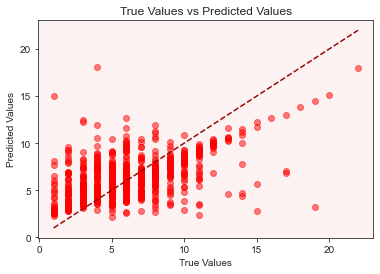



--------------------------------------------------


	---- Start Iteration 10 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-10 até 2021-12
Teste feito com o mês: 2022-01

X_train_cv shape:  (2920, 26)
X_train_tune shape:  (877, 26)
X_test shape:  (979, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.71102471943206602134
Feature: 1, Score: 0.08235195581818491317
Feature: 2, Score: -1.58078842482055437202
Feature: 3, Score: -0.09530659826230365728
Feature: 4, Score: 0.04518809666434819849
Feature: 5, Score: 0.00692711011453955687
Feature: 6, Score: 0.00606211710901474136
Feature: 7, Score: -0.06683049854367655029
Feature: 8, Score: 0.01665756484717706085
Feature: 9, Score: -

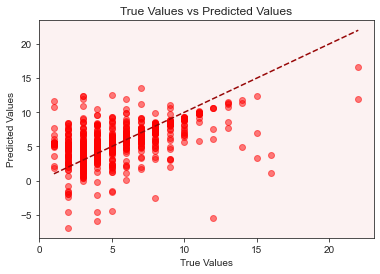



--------------------------------------------------


	---- Start Iteration 11 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-11 até 2022-01
Teste feito com o mês: 2022-02

X_train_cv shape:  (2920, 26)
X_train_tune shape:  (877, 26)
X_test shape:  (957, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.84866339332113605032
Feature: 1, Score: 0.04777132254225287256
Feature: 2, Score: 0.00679324513987630309
Feature: 3, Score: 0.05351997202781840629
Feature: 4, Score: -0.38455982585122161499
Feature: 5, Score: 0.33696658030966025743
Feature: 6, Score: -0.06173640879363718331
Feature: 7, Score: 0.01597884362551145118
Feature: 8, Score: -0.75010700538861896369
Feature: 9, Score: 0

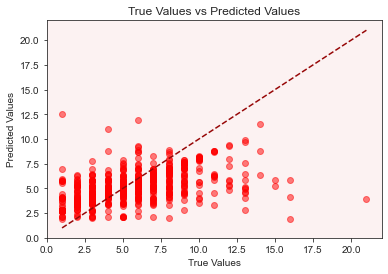



--------------------------------------------------


	---- Start Iteration 12 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-12 até 2022-02
Teste feito com o mês: 2022-03

X_train_cv shape:  (2905, 26)
X_train_tune shape:  (872, 26)
X_test shape:  (951, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.75373110085048522500
Feature: 1, Score: -0.03396632674538011681
Feature: 2, Score: 0.00397378400366888828
Feature: 3, Score: 0.03760535606590333785
Feature: 4, Score: -0.10219925950009153826
Feature: 5, Score: 0.05795672561131993278
Feature: 6, Score: 0.05216217905459726717
Feature: 7, Score: -0.05216217905491788570
Feature: 8, Score: -0.95234947684991277939
Feature: 9, Score: 

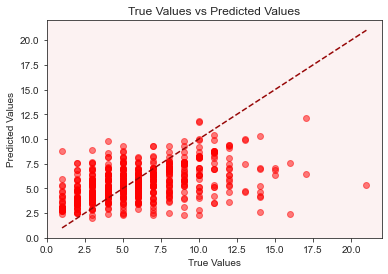



--------------------------------------------------


	---- Start Iteration 13 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-01 até 2022-03
Teste feito com o mês: 2022-04

X_train_cv shape:  (2887, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (955, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.73383755092739089143
Feature: 1, Score: 0.03482098597918087401
Feature: 2, Score: -0.13545019897047486102
Feature: 3, Score: -0.13745075064803241593
Feature: 4, Score: -0.15187217338751496376
Feature: 5, Score: -0.07832728055817461676
Feature: 6, Score: 0.34163104300761149013
Feature: 7, Score: 0.03267311910400644281
Feature: 8, Score: 0.02031910239495931733
Feature: 9, Score: 

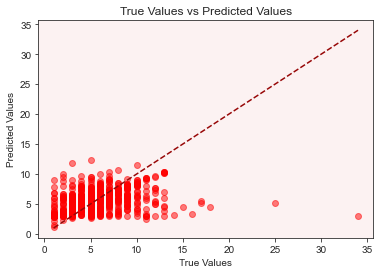



--------------------------------------------------


	---- Start Iteration 14 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-02 até 2022-04
Teste feito com o mês: 2022-05

X_train_cv shape:  (2863, 26)
X_train_tune shape:  (858, 26)
X_test shape:  (953, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.34364054560028511887
Feature: 1, Score: -0.22315507123683664403
Feature: 2, Score: -0.15226997861070579177
Feature: 3, Score: -0.16404234098619477344
Feature: 4, Score: -0.21768656267998451326
Feature: 5, Score: 0.06629736713608865017
Feature: 6, Score: 0.02523338420229098017
Feature: 7, Score: 0.01428883621285052634
Feature: 8, Score: 0.05344923509352588614
Feature: 9, Score: 

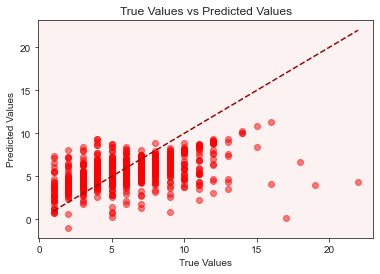



--------------------------------------------------


	---- Start Iteration 15 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-03 até 2022-05
Teste feito com o mês: 2022-06

X_train_cv shape:  (2859, 26)
X_train_tune shape:  (857, 26)
X_test shape:  (958, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.27462773531207806954
Feature: 1, Score: -0.20900802561557155212
Feature: 2, Score: 0.01621015322826936667
Feature: 3, Score: -0.19129230236983288393
Feature: 4, Score: -0.20608157549812305964
Feature: 5, Score: -0.12153702968186738675
Feature: 6, Score: 0.15114114695343155992
Feature: 7, Score: 0.09547475638972727219
Feature: 8, Score: -0.10421030573536450847
Feature: 9, Score:

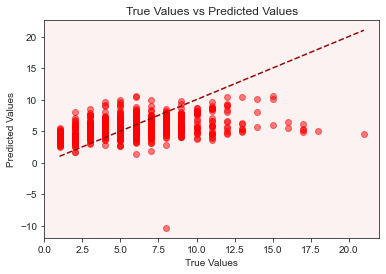



--------------------------------------------------


	---- Start Iteration 16 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-04 até 2022-06
Teste feito com o mês: 2022-07

X_train_cv shape:  (2866, 26)
X_train_tune shape:  (859, 26)
X_test shape:  (949, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.22429557252620480057
Feature: 1, Score: -0.22831914585406565266
Feature: 2, Score: -0.18065724666623733663
Feature: 3, Score: 0.11232056750181287907
Feature: 4, Score: -0.02060215903855446007
Feature: 5, Score: -0.00919830336095345431
Feature: 6, Score: -0.00612547783757426325
Feature: 7, Score: 0.14404237462509564272
Feature: 8, Score: -0.04391828454910400026
Feature: 9, Score

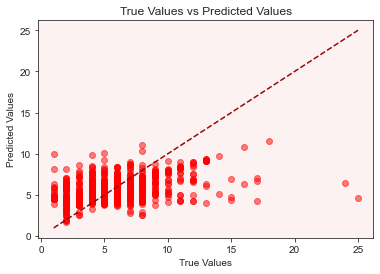



--------------------------------------------------


	---- Start Iteration 17 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-05 até 2022-07
Teste feito com o mês: 2022-08

X_train_cv shape:  (2860, 26)
X_train_tune shape:  (858, 26)
X_test shape:  (951, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.29145151466525565098
Feature: 1, Score: -0.20910330371012930684
Feature: 2, Score: -0.13466458717882204277
Feature: 3, Score: 0.13046352939753527722
Feature: 4, Score: -0.22861689443488911189
Feature: 5, Score: -0.07917898437115679366
Feature: 6, Score: 0.00650429528729319726
Feature: 7, Score: -0.01360990193258741938
Feature: 8, Score: -0.02896596980753221931
Feature: 9, Score

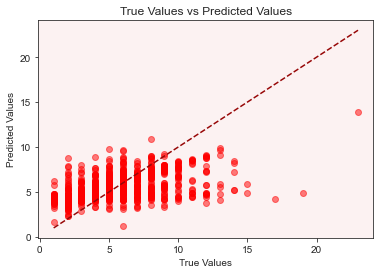



--------------------------------------------------


	---- Start Iteration 18 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-06 até 2022-08
Teste feito com o mês: 2022-09

X_train_cv shape:  (2858, 26)
X_train_tune shape:  (857, 26)
X_test shape:  (939, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.28984487516664514395
Feature: 1, Score: -0.06330617842820815411
Feature: 2, Score: -0.16916625011492461561
Feature: 3, Score: -0.23955813526098329591
Feature: 4, Score: 0.31460082116283011322
Feature: 5, Score: -0.39283592754795981783
Feature: 6, Score: 0.49291537643320010309
Feature: 7, Score: 0.18454311220363239787
Feature: 8, Score: 0.00620589541677620243
Feature: 9, Score: 

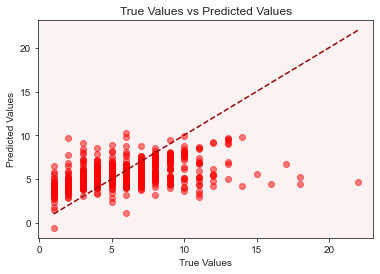



--------------------------------------------------


	---- Start Iteration 19 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-07 até 2022-09
Teste feito com o mês: 2022-10

X_train_cv shape:  (2839, 26)
X_train_tune shape:  (852, 26)
X_test shape:  (939, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.37138542176295397113
Feature: 1, Score: -0.24887123233424646163
Feature: 2, Score: -0.28153073637158987363
Feature: 3, Score: 0.05217033753427891690
Feature: 4, Score: -0.03796507463462796966
Feature: 5, Score: -0.10905538081867251210
Feature: 6, Score: 0.26950764899834711574
Feature: 7, Score: -0.00913342294639685366
Feature: 8, Score: 0.00913342294641056839
Feature: 9, Score:

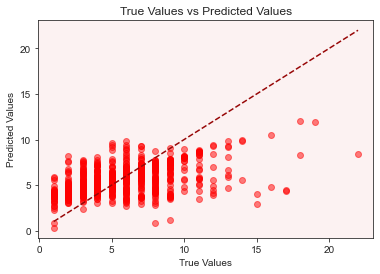



--------------------------------------------------


	---- Start Iteration 20 ----


	----- Iteration Info -----

Treino feito com os meses: 2022-08 até 2022-10
Teste feito com o mês: 2022-11

X_train_cv shape:  (2829, 26)
X_train_tune shape:  (849, 26)
X_test shape:  (949, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.996}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 1.37040308343521988199
Feature: 1, Score: -0.23966964281312530538
Feature: 2, Score: -0.25883337708693193724
Feature: 3, Score: -0.20053365052265659241
Feature: 4, Score: 0.00515883364410073611
Feature: 5, Score: 0.03073978056925678881
Feature: 6, Score: -0.05994537113744552448
Feature: 7, Score: -0.08447256092031993346
Feature: 8, Score: 0.21347120282110332301
Feature: 9, Score:

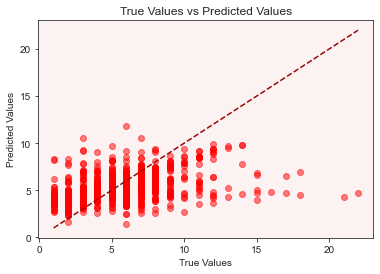


----------------------------


R² Mean of all iterations : 0.2655581218167663
Adjusted R² Mean of all iterations : 0.2622220912142902
MSE Mean of all iterations: 6.197751524326351
RMSE mean of all iterations: 2.48648972879268
MAE mean of all iterations: 1.7344796851159283
MAPE mean of all iterations: 0.46718967516253684


In [96]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, ridge, 'Ridge Regression')

In [40]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, lasso, 'Lasso Regression')

	------- Lasso Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 999 candidates, totalling 1998 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.015}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: -0.02521117090085664425
Feature: 1, Score: 0.01484421976344856876
Feature: 2, Score: 0.00000000000000000000
Feature: 3, Score: 0.00000000000000000000
Feature: 4, Score: 0.02483653573872325257
Feature: 5, Score: 0.00000000000000000000
Feature: 6, Score: -0.00000000000000000000
Feature: 7, Score: -0.00000000000000000000
Feature: 8, Score: -0.00000

In [41]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, ElasticNetRegression, 'ElasticNet Regression')

	------- ElasticNet Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 999 candidates, totalling 1998 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.031}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: -0.02472648404015302670
Feature: 1, Score: 0.01461438859921654343
Feature: 2, Score: 0.00000000000000000000
Feature: 3, Score: 0.00000000000000000000
Feature: 4, Score: 0.02427842433435333305
Feature: 5, Score: 0.00000000000000000000
Feature: 6, Score: -0.00000000000000000000
Feature: 7, Score: -0.00000000000000000000
Feature: 8, Score: -0.

In [215]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, gradientboostingreg, 'Gradient Boosting Regression')

	------- Gradient Boosting Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.361}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 0.66371058727884990613
Feature: 1, Score: 0.06793351985339173005
Feature: 2, Score: 0.00545917905886136867
Feature: 3, Score: 0.01115978126299372111
Feature: 4, Score: 0.01785826924393550327
Feature: 5, Score: 0.00841539324833428040
Feature: 6, Score: 0.02857900962996625174
Feature: 7, Score: 0.03835818136981460763
Feature: 8, Score: 

In [43]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, randomforestreg, 'Random Forest Regression')

	------- Random Forest Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 841 candidates, totalling 1682 fits


------------------------------------------------------------
Best Parameters:
{'clf__min_samples_leaf': 28, 'clf__min_samples_split': 12}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 0.45167215779665215170
Feature: 1, Score: 0.08416460759473151643
Feature: 2, Score: 0.05865887215223427459
Feature: 3, Score: 0.07490539401257229057
Feature: 4, Score: 0.07723073560572016327
Feature: 5, Score: 0.08534245599691195339
Feature: 6, Score: 0.03641942830622900418
Feature: 7, Score: 0.03079

KeyboardInterrupt: 

In [218]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, xgboost_regressor, 'XGBoost Regression')

	------- XGBoost Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 27 candidates, totalling 54 fits


------------------------------------------------------------
Best Parameters:
{'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 500}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 0.28227847814559936523
Feature: 1, Score: 0.05345422402024269104
Feature: 2, Score: 0.02380224131047725677
Feature: 3, Score: 0.00000000000000000000
Feature: 4, Score: 0.04370525479316711426
Feature: 5, Score: 0.04871462285518646240
Feature: 6, Score: 0.08356679230928421021
Feature: 7, Score: 

In [94]:
print(results.to_string(index=False), end=' ')

            Model  R² Mean  Adjusted R² Mean  MSE Mean  RMSE Mean  MAE Mean
Linear Regression     0.28              0.27      6.80       6.80      1.81
Linear Regression     0.28              0.27      6.80       6.80      1.81
Linear Regression     0.28              0.27      6.80       6.80      1.81
Linear Regression     0.27              0.26      6.20       6.20      1.73
Linear Regression     0.27              0.26      6.20       2.49      1.73
Linear Regression     0.27              0.26      6.20       2.49      1.73
Linear Regression     0.27              0.26      6.20       2.49      1.73
Linear Regression     0.27              0.26      6.20       2.49      1.73
Linear Regression     0.27              0.26      6.20       2.49      1.73 

-----

In [82]:
# Count the distinct values in the 'Feature' column
value_counts = feature_df['Feature'].value_counts()
# Get the values based on the condition
filtered_values = value_counts[value_counts > 10].index.tolist()
# Select rows based on the list of values
filtered_df = feature_df[feature_df['Feature'].isin(filtered_values)]
# Compute the mean
filtered_df = filtered_df.groupby('Feature')['Importance'].mean().reset_index()
# Sort values
filtered_df = filtered_df.sort_values('Importance', ascending=False)

Text(0.5, 1.0, 'Feature Importance')

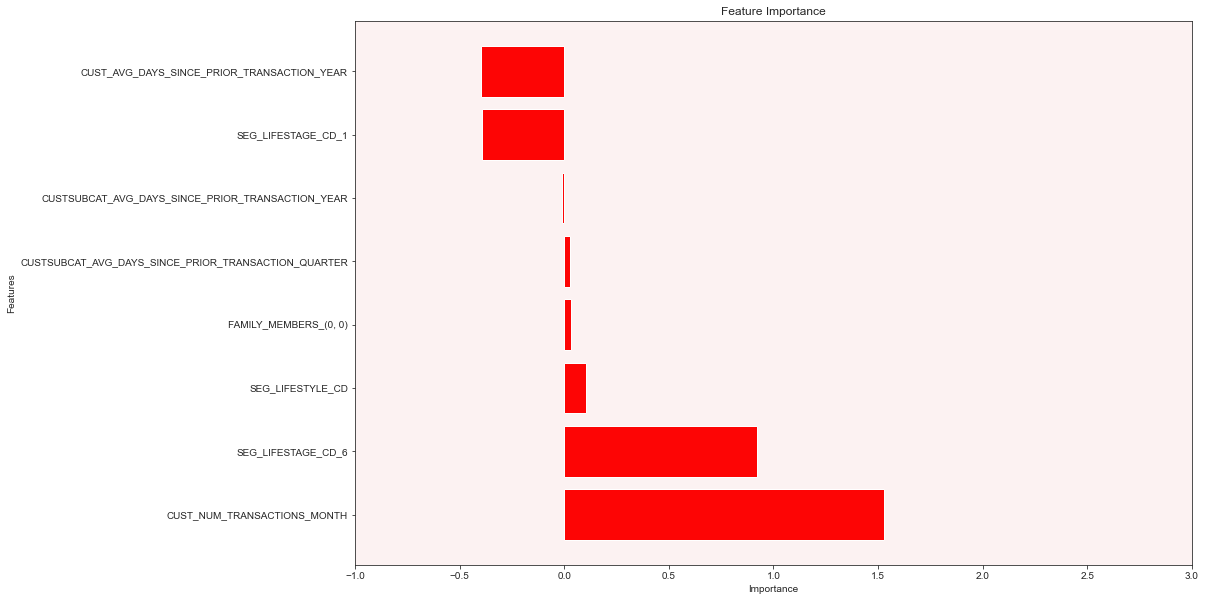

In [83]:
sns.set_style("ticks", {"axes.facecolor": "#fcf2f2"})
fig, ax = plt.subplots(figsize=(15, 10))
positive_df = filtered_df[filtered_df['Importance'] >= 0]
negative_df = filtered_df[filtered_df['Importance'] < 0]
bar1 = ax.barh(positive_df['Feature'],positive_df['Importance'],color='#FD0505')
bar2 = ax.barh(negative_df['Feature'],negative_df['Importance'], color='#FD0505')
ax.set_xlim(-1, 3)
# Set labels and title
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')